In [ ]:
# Install required packages
!pip install scikeras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime
import pickle
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from google.colab import files

In [ ]:
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    pd.set_option('display.max_columns', None)
    print("Before preprocessing:")
    print(data.head())
    # Drop irrelevant columns
    data = data.drop(['CustomerId','RowNumber', 'Surname'],axis = 1)
    # Encode Gender (Male=1, Female=0)
    label_encoder_gender = LabelEncoder()
    data['Gender'] = label_encoder_gender.fit_transform(data['Gender'])
    # One-hot encode Geography (France, Germany, Spain)
    onehot_encoder_geo = OneHotEncoder(sparse_output= False)
    geo_encoder = onehot_encoder_geo.fit_transform(data[['Geography']])
    geo_encoded_df = pd.DataFrame(geo_encoder, columns=onehot_encoder_geo.get_feature_names_out(['Geography']))
    # Combine one-hot encoded columns with original data
    data = pd.concat([data.drop('Geography', axis = 1),geo_encoded_df], axis =1)
    # Save encoders for later use
    with open('label_encoder_gender.pkl', 'wb') as file:
      pickle.dump(label_encoder_gender, file)
    with open('onehot_encoder_geo.pkl', 'wb') as file:
      pickle.dump(onehot_encoder_geo, file)
    print("\nAfter preprocessing:")
    print(data.head())  # <-- This prints processed table
    print("Shape after preprocessing:", data.shape)
    return data
# Use the raw file link
url = "https://raw.githubusercontent.com/krishnaik06/ANN-CLassification-Churn/6ac351aa3533f5cde56926032fb479a4e9c4d2ab/Churn_Modelling.csv"

data = load_and_preprocess_data(url)


Before preprocessing:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63  

In [ ]:
#Function to create ANN model
from tensorflow.keras import Input
def create_model(input_dim, lr=0.001):
  #Create a simple ANN model with dropout and batch normalization.

  model = Sequential([
    Input(shape=(12,)),  # Explicitly define the input layer
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  return model
  # after preprocessing
X = data.drop('Exited', axis=1).values
y = data['Exited'].values
model = create_model(input_dim=X.shape[1])



In [ ]:
print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:

# Function to evaluate model with k-fold cross-validation
def evaluate_model(X, y, n_splits=5, epochs=50, batch_size=32):
    # Ensure numpy arrays
    X = np.array(X)
    y = np.array(y)

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Scale numeric features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # Clear TF session and create model
        tf.keras.backend.clear_session()
        model = create_model(input_dim=X_train.shape[1], lr=0.001)

        early_stopping = EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )

        # Train the model
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0  # set to 1 to see training logs
        )

        # Predict
        y_pred_prob = model.predict(X_val).ravel()
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Append metrics
        scores['accuracy'].append(accuracy_score(y_val, y_pred))
        scores['precision'].append(precision_score(y_val, y_pred, zero_division=0))
        scores['recall'].append(recall_score(y_val, y_pred, zero_division=0))
        scores['f1'].append(f1_score(y_val, y_pred, zero_division=0))

        print(
            f"Fold {fold}: acc={scores['accuracy'][-1]:.4f}, "
            f"precision={scores['precision'][-1]:.4f}, "
            f"recall={scores['recall'][-1]:.4f}, "
            f"f1={scores['f1'][-1]:.4f}"
        )

    # Return per-fold and aggregated summary
    summary = {m: (np.mean(v), np.std(v)) for m, v in scores.items()}
    return scores, summary

In [ ]:

# Function to plot training history
def plot_training_history(history):
    """Plot training and validation loss and accuracy."""
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix for model predictions."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Not Churn', 'Churn'],
        yticklabels=['Not Churn', 'Churn']
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
# Function to plot feature importance
def plot_feature_importance(importance_df):
    """Plot bar chart of feature importance."""
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [ ]:
# Function to calculate feature importance
def calculate_feature_importance(model, X_test, y_test, feature_names):
    """Calculate feature importance using permutation importance."""
    from sklearn.inspection import permutation_importance
    results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importance = pd.DataFrame({'Feature': feature_names, 'Importance': results.importances_mean})
    return importance.sort_values(by='Importance', ascending=False)

In [ ]:
def predict_churn_bulk(input_data=None, input_file=None):
    """Perform bulk predictions from a list of dictionaries or a CSV file."""
    import pickle
    import pandas as pd
    import tensorflow as tf
    from google.colab import files  # Only if using in Colab, else remove

    # Load preprocessors and model
    with open('label_encoder_gender.pkl', 'rb') as file:
        label_encoder_gender = pickle.load(file)
    with open('onehot_encoder_geo.pkl', 'rb') as file:
        onehot_encoder_geo = pickle.load(file)
    with open('scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)
    model = tf.keras.models.load_model('improved_model.keras')

    # Handle input: either a list of dictionaries or a CSV file
    if input_file:
        input_df = pd.read_csv(input_file)
    elif input_data:
        input_df = pd.DataFrame(input_data)
    else:
        raise ValueError("Must provide either input_data or input_file")

    # Validate input
    required_columns = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
                       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
    if not all(col in input_df.columns for col in required_columns):
        raise ValueError("Input data must contain all required columns: " + ", ".join(required_columns))

    # Encode categorical variables
    input_df['Gender'] = label_encoder_gender.transform(input_df['Gender'])
    geo_encoded = onehot_encoder_geo.transform(input_df[['Geography']])
    geo_encoded_df = pd.DataFrame(geo_encoded, columns=onehot_encoder_geo.get_feature_names_out(['Geography']))
    input_df = pd.concat([input_df.drop('Geography', axis=1), geo_encoded_df], axis=1)

    # Scale features
    input_scaled = scaler.transform(input_df)

    # Predict churn probabilities and labels
    predictions = model.predict(input_scaled, batch_size=32)
    prediction_probas = predictions.flatten()
    prediction_labels = (predictions > 0.5).astype(int).flatten()

    # Create result DataFrame
    result_df = input_df.copy()
    result_df['Churn_Probability'] = prediction_probas
    result_df['Churn_Prediction_Numeric'] = prediction_labels
    result_df['Churn_Prediction'] = ['likely to churn' if pred == 1 else 'not likely to churn' for pred in prediction_labels]

    # Save results to CSV and download if using Google Colab
    result_df.to_csv('churn_predictions.csv', index=False)
    try:
        files.download('churn_predictions.csv')
    except:
        pass  # If not in Colab, ignore

    return result_df


In [ ]:
import datetime
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

def main(file_name):
    # 1) Load & preprocess (this function should already save label & onehot encoders)
    data = load_and_preprocess_data(file_name)

    # 2) Features and target
    X = data.drop('Exited', axis=1)
    y = data['Exited'].values

    # 3) Train/test split (stratify to keep class ratio)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Keep raw (unscaled) copies for cross-validation later
    X_train_raw = X_train.copy()
    X_test_raw = X_test.copy()

    # 4) Scale features for the final model training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save scaler for reuse in production/prediction
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # 5) Create and train model (pass correct input_dim)
    model = create_model(input_dim=X_train.shape[1], lr=0.001)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[tensorboard_callback, early_stopping],
        verbose=1
    )

    # 6) Plots and test evaluation
    plot_training_history(history)

    y_pred_prob = model.predict(X_test_scaled).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("\nTest set performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred, zero_division=0):.4f}")

    plot_confusion_matrix(y_test, y_pred)

    # 7) Feature importance for Keras: wrap model so permutation_importance can call .predict()
    try:
        from sklearn.inspection import permutation_importance
        from sklearn.metrics import make_scorer, accuracy_score as acc_score

        class KerasSklearnWrapper:
            def __init__(self, keras_model):
                self.keras_model = keras_model
            def predict(self, X):
                preds = self.keras_model.predict(X)
                return (preds > 0.5).astype(int).ravel()

        wrapper = KerasSklearnWrapper(model)
        # Use scaled test set because model was trained on scaled data
        results = permutation_importance(
            wrapper, X_test_scaled, y_test,
            n_repeats=10, random_state=42,
            scoring=make_scorer(acc_score)
        )
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': results.importances_mean
        }).sort_values('Importance', ascending=False)

        print("\nFeature Importance:")
        print(importance_df)
        plot_feature_importance(importance_df)

    except Exception as e:
        print("Feature importance skipped (not available):", e)

    # 8) K-fold cross-validation evaluation
    # Pass RAW training data; evaluate_model will scale inside folds to avoid leakage
    scores, summary = evaluate_model(X_train_raw, y_train, n_splits=5, epochs=30, batch_size=32)
    print("\nCross-validation summary (mean ± 2*std):")
    for metric, (mean, std) in summary.items():
        print(f"{metric.capitalize()}: {mean:.4f} (+/- {std*2:.4f})")

    # 9) Save model
    model.save('improved_model.keras')
    print("\nModel saved to improved_model.keras")

    # 10) Try Colab downloads (guarded)
    try:
        from google.colab import files
        files.download('label_encoder_gender.pkl')
        files.download('onehot_encoder_geo.pkl')
        files.download('scaler.pkl')
        files.download('improved_model.keras')
    except Exception:
        print("Download step skipped (not running in Colab). Files are saved in the working directory.")

# Run main (pass file_name you got from files.upload())
# main(file_name)


Before preprocessing:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63  

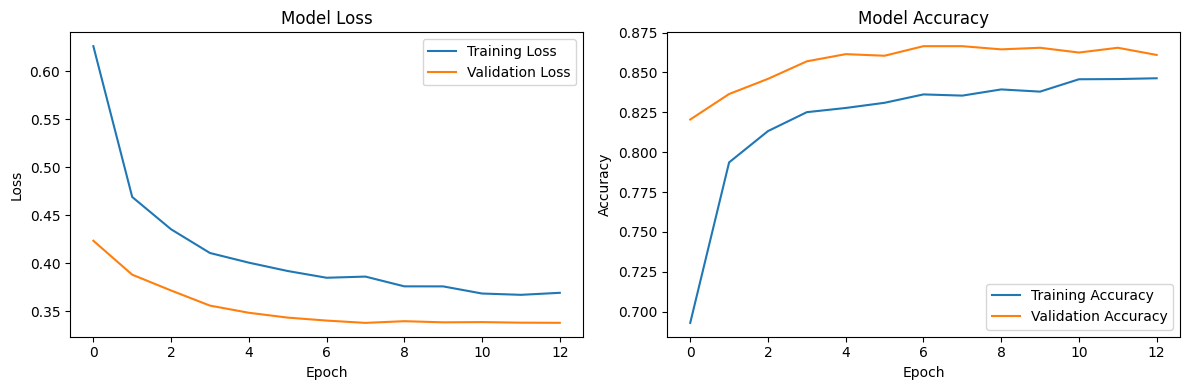

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Test set performance:
Accuracy: 0.8665
Precision: 0.7846
Recall: 0.4742
F1-score: 0.5911


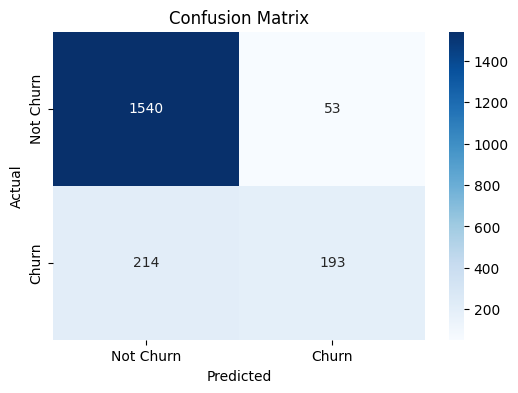

Feature importance skipped (not available): The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <__main__.main.<locals>.KerasSklearnWrapper object at 0x7ccd117102d0> instead.
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1: acc=0.8581, precision=0.7619, recall=0.4417, f1=0.5592
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2: acc=0.8669, precision=0.7653, recall=0.5000, f1=0.6048
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3: acc=0.8694, precision=0.7910, recall=0.4877, f1=0.6034
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 4: acc=0.8569, precision=0.7539, recall=0.4417, f1=0.5571
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5: acc=0.8450, precision=0.6950, recall=0.4264, f1=0.5285

Cross-validation summary (mean ± 2*std):
Accuracy: 0.8593 (+/- 0.0172)
Precision: 0.7534 (+/- 0.0635)
Recall: 0.4595 (+/- 0.0577)
F1: 0.5706 (+/- 0.0589)

Model saved to improved_model.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
main("https://raw.githubusercontent.com/krishnaik06/ANN-CLassification-Churn/6ac351aa3533f5cde56926032fb479a4e9c4d2ab/Churn_Modelling.csv"
)

In [ ]:

total_customers = len(result_df)
churners = sum(result_df['Churn_Prediction'] == 'likely to churn')
churn_rate_percent = (churners / total_customers) * 100
print(f"Predicted churn rate: {churn_rate_percent:.2f}%")


Predicted churn rate: 0.00%


In [ ]:
print(data['Exited'].value_counts(normalize=True))


Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64
